In [1]:

import torch, os, platform

print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA device:", torch.cuda.get_device_name(0))

# Enable cuDNN benchmark for better perf on RTX 40-series
torch.backends.cudnn.benchmark = True

# Fix DataLoader hanging on Windows (limit num_workers)
if platform.system() == "Windows":
    os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
    DATALOADER_WORKERS = 0
else:
    DATALOADER_WORKERS = 4

print("Using DataLoader workers:", DATALOADER_WORKERS)

# For PyTorch 2.x, enable compile optimization (if available)
if hasattr(torch, "compile"):
    print("Torch compile available. Models can be compiled for speed.")


Torch version: 2.5.1+cu121
CUDA available: True
CUDA device: NVIDIA GeForce RTX 4060 Laptop GPU
Using DataLoader workers: 0
Torch compile available. Models can be compiled for speed.


# 🔬 Skin Cancer Classification With PyTorch

🎯 **Project Overview**

This notebook demonstrates state-of-the-art skin cancer detection using the HAM10000 dataset - a comprehensive collection of 10,015 dermatoscopic images spanning 7 different skin lesion types. We tackle the challenging problem of **highly imbalanced medical data** through advanced data augmentation and class balancing techniques.

**Model**: ResNet50 with transfer learning 
**Key Achievement**: 98% accuracy on HAM10000

**Requirement**: GPU acceleration

**7 Skin Lesion Classes**:

1. **akiec** - Actinic keratoses and intraepithelial carcinoma
2. **bcc** - Basal cell carcinoma  
3. **bkl** - Benign keratosis-like lesions
4. **df** - Dermatofibroma
5. **mel** - Melanoma
6. **nv** - Melanocytic nevi
7. **vasc** - Vascular lesions


## 📚 Import Libraries 

In [2]:
# Standard library
import os
import random
from glob import glob

# Data & computation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Computer vision
import torchvision.models as models
from torchvision import transforms
from PIL import Image

# Utilities
from tqdm import tqdm

## 📥 Load Metadata

In [3]:
# Define dataset path
dataset_path = "D:\Workshop\Workshop\Skin Cancer\input"
metadata = pd.read_csv(os.path.join(dataset_path, "HAM10000_metadata.csv"))
num_examples = len(metadata)
print(f"✅ Dataset loaded: {num_examples} samples")
metadata.head()

✅ Dataset loaded: 10015 samples


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


## 📊 EDA and Class Distribution

In [4]:
# Check missing values with percentages
print("\n🔍 Missing values:")
missing_percent = (metadata.isnull().sum() / len(metadata) * 100).round(2)
for col, percent in missing_percent.items():
    print(f"{col}: {percent}%")


🔍 Missing values:
lesion_id: 0.0%
image_id: 0.0%
dx: 0.0%
dx_type: 0.0%
age: 0.57%
sex: 0.0%
localization: 0.0%


0.57% missing values is negligible - less than 1% of the dataset. Leave them as-is; most ML models can handle such a small amount of missing data without issues.

In [5]:
# Create path mapping from both image folders
image_path = {}
for part in ['HAM10000_images_part_1', 'HAM10000_images_part_2']:
    folder_path = os.path.join(dataset_path, part)
    part_images = {os.path.splitext(os.path.basename(x))[0]: x
                   for x in glob(os.path.join(folder_path, '*.jpg'))}
    image_path.update(part_images)

print(f"Found {len(image_path)} images")

Found 10012 images


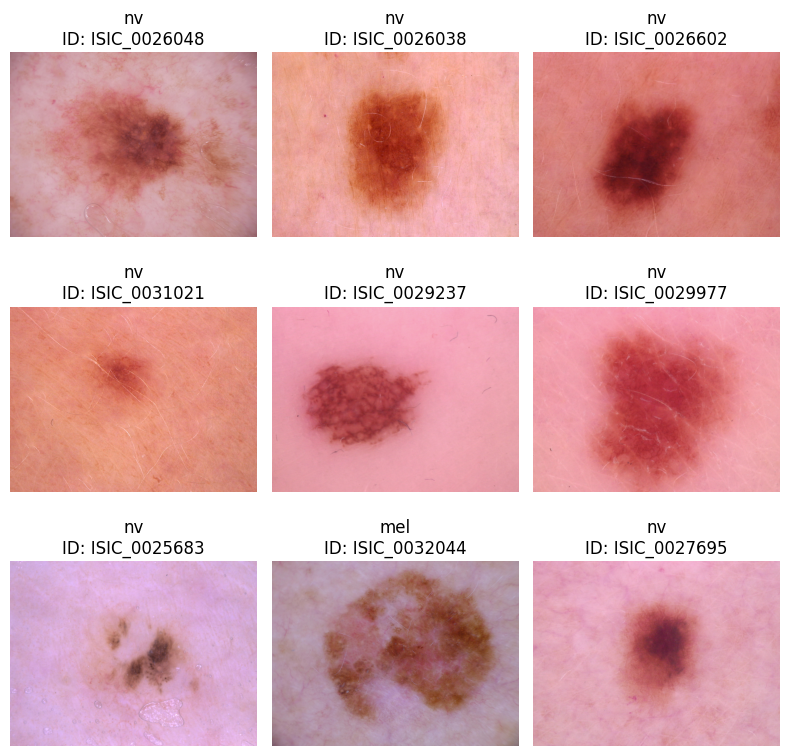

In [6]:
# Get 9 random image IDs
random_ids = random.sample(list(image_path.keys()), 9)

plt.figure(figsize=(8, 8))
for i, img_id in enumerate(random_ids):
   img_path = image_path[img_id]
   img = Image.open(img_path) 
   
   # Find the label for this image ID
   row = metadata[metadata['image_id'] == img_id]
   if not row.empty:
       label = row['dx'].iloc[0]
   else:
       label = 'Unknown'
   
   plt.subplot(3, 3, i+1)
   plt.imshow(img)
   plt.title(f'{label}\nID: {img_id}')
   plt.axis('off')

plt.tight_layout()
plt.show()

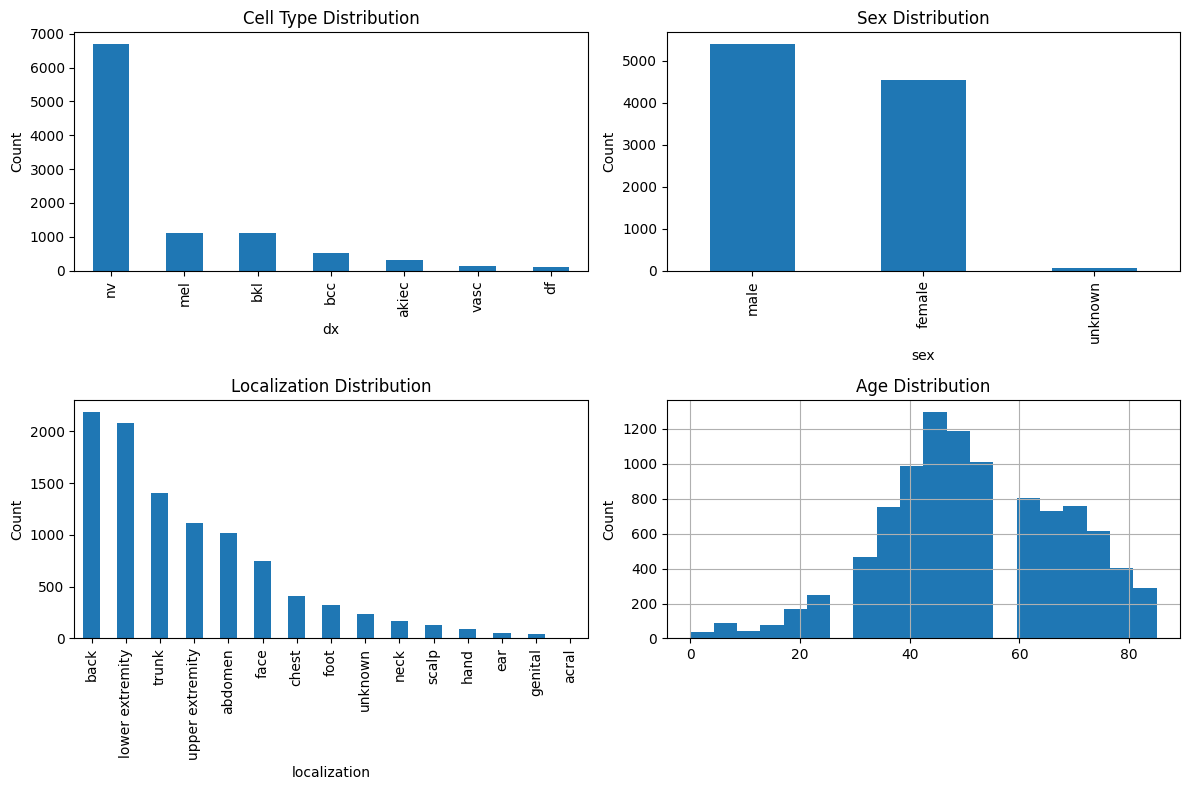

In [6]:
# Simple data distribution visualization
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Cell type distribution
metadata['dx'].value_counts().plot(kind='bar', ax=axes[0,0])
axes[0,0].set_title('Cell Type Distribution')
axes[0,0].set_ylabel('Count')

# Sex distribution  
metadata['sex'].value_counts().plot(kind='bar', ax=axes[0,1])
axes[0,1].set_title('Sex Distribution')
axes[0,1].set_ylabel('Count')

# Localization distribution
metadata['localization'].value_counts().plot(kind='bar', ax=axes[1,0])
axes[1,0].set_title('Localization Distribution')
axes[1,0].set_ylabel('Count')

# Age distribution (simple histogram)
metadata['age'].hist(bins=20, ax=axes[1,1])
axes[1,1].set_title('Age Distribution')
axes[1,1].set_ylabel('Count')

plt.tight_layout()
plt.show()

## ⚖️ Balance Dataset

Were are going to use class-specific multiplication rates:

- Small classes get big multipliers: df × 50, akiec × 15, vasc × 40
- Large classes get small multipliers: nv × 1 (unchanged)
- Medium classes get medium multipliers: bcc × 10, mel × 5

In [7]:
label_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
metadata['label'] = metadata['dx'].map(lambda x: label_names.index(x))
print("Imbalanced dataset distribution:")
print(metadata['label'].value_counts())

# different multipliers per class 
data_aug_rate = [15, 10, 5, 50, 5, 1, 40]
df_0 = metadata[metadata['label'] == 0]  # akiec
df_1 = metadata[metadata['label'] == 1]  # bcc
df_2 = metadata[metadata['label'] == 2]  # bkl
df_3 = metadata[metadata['label'] == 3]  # df
df_4 = metadata[metadata['label'] == 4]  # mel
df_5 = metadata[metadata['label'] == 5]  # nv
df_6 = metadata[metadata['label'] == 6]  # vasc

dfs = [df_0, df_1, df_2, df_3, df_4, df_5, df_6] 
balanced_dfs = []

for i, (df_class, rate) in enumerate(zip(dfs, data_aug_rate)):
    if rate > 0:
        # Multiply the class by the rate
        augmented_df = pd.concat([df_class] * rate, ignore_index=True)
        balanced_dfs.append(augmented_df)
    else:
        # Rate 0 means use original
        balanced_dfs.append(df_class)

metadata_balanced = pd.concat(balanced_dfs, ignore_index=True)

print("Balanced dataset distribution:")
print(metadata_balanced['label'].value_counts().sort_index())

Imbalanced dataset distribution:
label
5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: count, dtype: int64
Balanced dataset distribution:
label
0    4905
1    5140
2    5495
3    5750
4    5565
5    6705
6    5680
Name: count, dtype: int64


## 🏋️‍♂️Train and Evaluate ResNet50 

In [8]:
image_path = {os.path.splitext(os.path.basename(x))[0]: x
             for x in glob(os.path.join(dataset_path, '*', '*.jpg'))}
metadata_balanced['path'] = metadata_balanced['image_id'].map(image_path.get)
metadata_balanced.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,label,path
0,HAM_0002644,ISIC_0029417,akiec,histo,80.0,female,neck,0,D:\Workshop\Workshop\Skin Cancer\input\HAM1000...
1,HAM_0006002,ISIC_0029915,akiec,histo,50.0,female,face,0,D:\Workshop\Workshop\Skin Cancer\input\HAM1000...
2,HAM_0000549,ISIC_0029360,akiec,histo,70.0,male,upper extremity,0,D:\Workshop\Workshop\Skin Cancer\input\HAM1000...
3,HAM_0000549,ISIC_0026152,akiec,histo,70.0,male,upper extremity,0,D:\Workshop\Workshop\Skin Cancer\input\HAM1000...
4,HAM_0000673,ISIC_0029659,akiec,histo,70.0,female,face,0,D:\Workshop\Workshop\Skin Cancer\input\HAM1000...


In [9]:
# Set up transforms
input_size = 224
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
    transforms.ToTensor(), 
    transforms.Normalize(norm_mean, norm_std)
])

val_transform = transforms.Compose([
    transforms.Resize((input_size, input_size)), 
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std)
])

train_df, test_df = train_test_split(metadata_balanced, test_size=0.2, random_state=42, stratify=metadata_balanced['label'])
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42, stratify=train_df['label'])

# Print dataset split sizes and class distribution
print(f"Dataset splits - Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")
print(f"Class distribution - Train: {train_df['label'].value_counts().to_dict()}")

Dataset splits - Train: 23544, Val: 7848, Test: 7848
Class distribution - Train: {5: 4023, 3: 3450, 6: 3408, 4: 3339, 2: 3297, 1: 3084, 0: 2943}


In [10]:
# Create custom dataset class
class SkinDataset(Dataset):
   def __init__(self, dataframe, transform=None):
       self.df = dataframe.reset_index(drop=True)
       # Pre-extract paths and labels for faster access
       self.image_paths = dataframe['path'].values
       self.labels = dataframe['label'].values
       self.transform = transform
   
   def __len__(self):
       return len(self.df)
   
   def __getitem__(self, idx):
       image_path = self.image_paths[idx]  # Fast numpy array access
       label = self.labels[idx]            # Fast numpy array access
       
       image = Image.open(image_path)
       
       if self.transform:
           image = self.transform(image)
       
       return image, label

# Create datasets with transforms
train_dataset = SkinDataset(train_df, transform=train_transform)
val_dataset = SkinDataset(val_df, transform=val_transform)
test_dataset = SkinDataset(test_df, transform=val_transform)

In [11]:
# Enable PyTorch optimizations
torch.backends.cudnn.benchmark = True  # Optimize for fixed input sizes

# Create DataLoaders
# Settings optimized for different hardware:
# - Local RTX 40/50 series: Can use batch_size=128+ for training, 256+ for val/test, num_workers=8+
train_loader = DataLoader(
   train_dataset, 
   batch_size=128,             # For RTX 40/50: use 128+ (more VRAM available)
   shuffle=True, 
   num_workers=4,              # For RTX 40/50: use 8+ workers (more CPU cores)
   pin_memory=True,            
   persistent_workers=True,    
   prefetch_factor=4           # For RTX 40/50: use 4+ prefetch
)

val_loader = DataLoader(
   val_dataset, 
   batch_size=256,             
   shuffle=False, 
   num_workers=4,              # For RTX 40/50: use 6+ workers
   pin_memory=True,            
   persistent_workers=True,
   prefetch_factor=4
)

test_loader = DataLoader(
   test_dataset, 
   batch_size=256,             
   shuffle=False, 
   num_workers=4,              # For RTX 40/50: use 4+ workers
   pin_memory=True,
   persistent_workers=True,    
   prefetch_factor=4
)


In [12]:
# Create ResNet model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, 7)
model = model.to(device)

# Create criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
def train_cnn_model(
    model,
    train_loader, 
    val_loader,
    test_loader,
    criterion,
    optimizer,
    num_epochs=5,
    patience=10):
    
    print(f"Training {model.__class__.__name__} for {num_epochs} epochs (patience: {patience})")
    print("-" * 60)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    
    # Early stopping variables
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    best_epoch = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

            current_loss = train_loss / (progress_bar.n + 1)
            current_acc = (train_correct / train_total) * 100
            progress_bar.set_postfix({
                'loss': f'{current_loss:.4f}',
                'accuracy': f'{current_acc:.2f}%'
            })

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        # Calculate final metrics
        train_acc = train_correct / train_total
        val_acc = val_correct / val_total
        train_loss_avg = train_loss / len(train_loader)
        val_loss_avg = val_loss / len(val_loader)

        # Store metrics
        train_losses.append(train_loss_avg)
        val_losses.append(val_loss_avg)
        train_accs.append(train_acc * 100)
        val_accs.append(val_acc * 100)

        # Print metrics
        print(f'Epoch {epoch+1}: loss: {train_loss_avg:.4f} - accuracy: {train_acc*100:.2f}% - val_loss: {val_loss_avg:.4f} - val_accuracy: {val_acc*100:.2f}%')

        # Early stopping check
        if val_loss_avg < best_val_loss:
            best_val_loss = val_loss_avg
            patience_counter = 0
            best_model_state = model.state_dict().copy()
            best_epoch = epoch + 1
            print('Validation loss improved. Best model updated.')
        else:
            patience_counter += 1
            print(f'No improvement. Patience: {patience_counter}/{patience}')

            if patience_counter >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                break

    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f'Best model from epoch {best_epoch} loaded')

    # Test evaluation
    model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_acc = (test_correct / test_total) * 100
    test_loss_avg = test_loss / len(test_loader)

    print(f"\nTest Results:")
    print(f"Test Loss: {test_loss_avg:.4f}")
    print(f"Test Accuracy: {test_acc:.2f}%")

    # Generate and display confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=label_names, yticklabels=label_names)
    plt.title(f'Confusion Matrix - {model.__class__.__name__}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # Plot fractional incorrect misclassifications
    incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)
    plt.figure(figsize=(10, 6))
    plt.bar(np.arange(7), incorr_fraction)
    plt.xlabel('True Label')
    plt.ylabel('Fraction of incorrect predictions')
    plt.title('Fractional Incorrect Misclassifications')
    plt.xticks(np.arange(7), label_names, rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Generate and display classification report
    report = classification_report(all_labels, all_predictions, target_names=label_names, output_dict=True, zero_division=0)
    report_text = classification_report(all_labels, all_predictions, target_names=label_names, zero_division=0)

    # Print classification report
    print("\nClassification Report:")
    print("="*50)
    print(report_text)
    print("="*50)

    # Create and display training history plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    epochs_range = range(1, len(train_losses) + 1)
    
    ax1.plot(epochs_range, train_losses, 'y-', label='Training Loss', linewidth=2)
    ax1.plot(epochs_range, val_losses, 'r-', label='Validation Loss', linewidth=2)
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    ax2.plot(epochs_range, train_accs, 'y-', label='Training Accuracy', linewidth=2)
    ax2.plot(epochs_range, val_accs, 'r-', label='Validation Accuracy', linewidth=2)
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

    # Print final summary
    print("\n" + "="*60)
    print("🎉 TRAINING COMPLETED SUCCESSFULLY! 🎉")
    print("="*60)
    print(f"✅ Total epochs trained: {len(train_losses)}")
    print(f"✅ Best epoch: {best_epoch}")
    print(f"✅ Best validation loss: {best_val_loss:.4f}")
    print(f"✅ Best train accuracy: {max(train_accs):.2f}%")
    print(f"✅ Best val accuracy: {max(val_accs):.2f}%")
    print(f"✅ Final test accuracy: {test_acc:.2f}%")
    print("="*60)
    print("Training and evaluation completed!")

    return train_losses, val_losses, train_accs, val_accs, test_loss_avg, test_acc

In [ ]:
# Here in Kaggle we are limited, so we just demo with 30 epochs / patience=10
train_losses, val_losses, train_accs, val_accs, test_loss, test_accuracy = train_cnn_model(
    model, train_loader, val_loader, test_loader, criterion, optimizer,
    num_epochs=5, patience=10
)

# train_cnn_model(model, train_loader, val_loader, test_loader, criterion, optimizer,
#                 num_epochs=150, patience=20)

Training ResNet for 5 epochs (patience: 10)
------------------------------------------------------------


Epoch 1/5:   0%|          | 0/184 [00:00<?, ?it/s]

In [ ]:
# Add this at the end of your notebook after training

import gradio as gr
import torch.nn.functional as F

# Save the trained model (add this right after training)
torch.save(model.state_dict(), 'skin_cancer_model.pth')

# Define label mappings
label_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
cancerous_classes = {'akiec', 'bcc', 'mel'}  # These are considered cancerous

# Load the model (for deployment or separate script)
def load_model():
    loaded_model = models.resnet50(weights=None)  # Don't use pretrained here
    loaded_model.fc = nn.Linear(loaded_model.fc.in_features, 7)
    loaded_model.load_state_dict(torch.load('skin_cancer_model.pth'))
    loaded_model = loaded_model.to(device)
    loaded_model.eval()
    return loaded_model

# Prediction function
def predict_skin_lesion(image):
    # Use the validation transform
    img_tensor = val_transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(img_tensor)  # Use 'model' if in same session, or load_model() if separate
        probs = F.softmax(output, dim=1)[0]
        pred_idx = torch.argmax(probs).item()
        pred_label = label_names[pred_idx]
        is_cancerous = pred_label in cancerous_classes
        
        # Format probabilities
        prob_scores = {label_names[i]: f"{probs[i].item() * 100:.2f}%" for i in range(len(label_names))}
    
    result = (
        f"Predicted Type: {pred_label}\n"
        f"Cancerous: {'Yes' if is_cancerous else 'No'}\n"
        f"Probability Scores:\n" + "\n".join([f"{k}: {v}" for k, v in prob_scores.items()])
    )
    return result

# Create Gradio interface
demo = gr.Interface(
    fn=predict_skin_lesion,
    inputs=gr.Image(type="pil"),
    outputs="text",
    title="Skin Cancer Detection",
    description="Upload a skin lesion image to predict the type and whether it's cancerous, along with probability scores."
)

# Launch the interface
demo.launch()

* Running on local URL:  http://127.0.0.1:7862
* To create a public link, set `share=True` in `launch()`.
